# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(70, 6)


,title,price,year,link,brand,age
0,2016 chevy silverado 2500 4wd truck,18500,2016.0,https://charlottesville.craigslist.org/cto/d/s...,chevy,9.0
1,2013 subaru outback,7750,2013.0,https://charlottesville.craigslist.org/cto/d/c...,subaru,12.0
2,2014 audi a6,9500,2014.0,https://charlottesville.craigslist.org/cto/d/c...,audi,11.0
3,2019 chevy equinox ls,12500,2019.0,https://charlottesville.craigslist.org/cto/d/c...,chevy,6.0
4,2010 international 400 box truck,16500,2010.0,https://charlottesville.craigslist.org/cto/d/r...,missing,15.0


With the data in and wrangled, we can now do some analysis:

count       70.000000
mean     10919.971429
std      12479.495607
min       1000.000000
25%       3500.000000
50%       7200.000000
75%      13625.000000
max      79999.000000
Name: price, dtype: float64


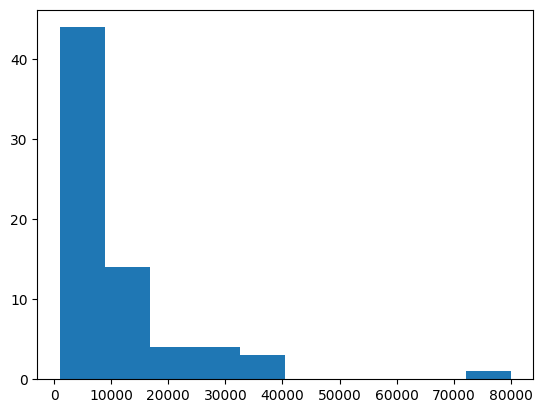

count    62.000000
mean     17.161290
std      12.679134
min       3.000000
25%      11.000000
50%      14.500000
75%      19.000000
max      70.000000
Name: age, dtype: float64


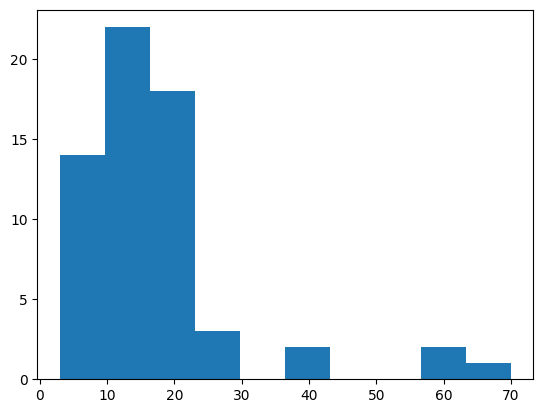

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        1.0   3500.000000           NaN   3500.0   3500.0   3500.0   
audi         1.0   9500.000000           NaN   9500.0   9500.0   9500.0   
bmw          3.0  13743.333333   3029.460898  10500.0  12365.0  14230.0   
chevrolet    2.0  13500.000000  14142.135624   3500.0   8500.0  13500.0   
chevy        5.0  15499.800000   8269.295629   2999.0  12500.0  18500.0   
dodge        2.0  27000.000000  18384.776311  14000.0  20500.0  27000.0   
ford         6.0  12082.500000  12527.603023   1000.0   2100.0   7647.5   
honda        6.0   4391.666667   2017.031647   1000.0   3750.0   4700.0   
jeep         5.0   8990.000000   5182.952826   3250.0   5700.0   7500.0   
lexus        1.0   5000.000000           NaN   5000.0   5000.0   5000.0   
mazda        1.0   1000.000000           NaN   1000.0   1000.0   1000.0   
missing     23.0  11601.695652  17561.745273   1000.0   2800.0   5000.0   
porsche      1.0  23900.000000           NaN  23900.0  23900.0  23900.0   
subaru       3.0   5583.333333   3125.833222   2000.0   4500.0   7000.0   
toyota       8.0  10325.000000  10305.996867   3500.0   5900.0   7450.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.0   7500.0   
volvo        1.0   4285.000000           NaN   4285.0   4285.0   4285.0   

                               
                 75%      max  
brand                          
acura        3500.00   3500.0  
audi         9500.00   9500.0  
bmw         15365.00  16500.0  
chevrolet   18500.00  23500.0  
chevy       18500.00  25000.0  
dodge       33500.00  40000.0  
ford        21373.75  30000.0  
honda        5350.00   6950.0  
jeep        12500.00  16000.0  
lexus        5000.00   5000.0  
mazda        1000.00   1000.0  
missing     10000.00  79999.0  
porsche     23900.00  23900.0  
subaru       7375.00   7750.0  
toyota       8225.00  35500.0  
volkswagen   7500.00   7500.0  
volvo        4285.00   4285.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                     
           count       mean        std   min   25%   50%    75%   max
brand                                                                
acura        1.0  18.000000        NaN  18.0  18.0  18.0  18.00  18.0
audi         1.0  11.000000        NaN  11.0  11.0  11.0  11.00  11.0
bmw          3.0  13.000000   6.928203   9.0   9.0   9.0  15.00  21.0
chevrolet    1.0  70.000000        NaN  70.0  70.0  70.0  70.00  70.0
chevy        5.0  16.200000  13.516656   6.0   9.0   9.0  18.00  39.0
dodge        2.0  10.000000   1.414214   9.0   9.5  10.0  10.50  11.0
ford         6.0  13.000000   8.763561   4.0   5.0  12.5  20.75  23.0
honda        6.0  17.000000   4.242641  12.0  13.5  17.0  20.50  22.0
jeep         5.0  22.600000  11.436783  11.0  17.0  19.0  25.00  41.0
lexus        1.0  17.000000        NaN  17.0  17.0  17.0  17.00  17.0
mazda        1.0  14.000000        NaN  14.0  14.0  14.0  14.00  14.0
missing     17.0  17.941176  16.199809   5.0  10.0  13.0  17.00  62.0
porsche      1.0  12.000000        NaN  12.0  12.0  12.0  12.00  12.0
subaru       3.0  16.666667   8.962886  11.0  11.5  12.0  19.50  27.0
toyota       7.0  14.000000   6.557439   3.0  12.0  15.0  15.50  25.0
volkswagen   1.0  17.000000        NaN  17.0  17.0  17.0  17.00  17.0
volvo        1.0  19.000000        NaN  19.0  19.0  19.0  19.00  19.0

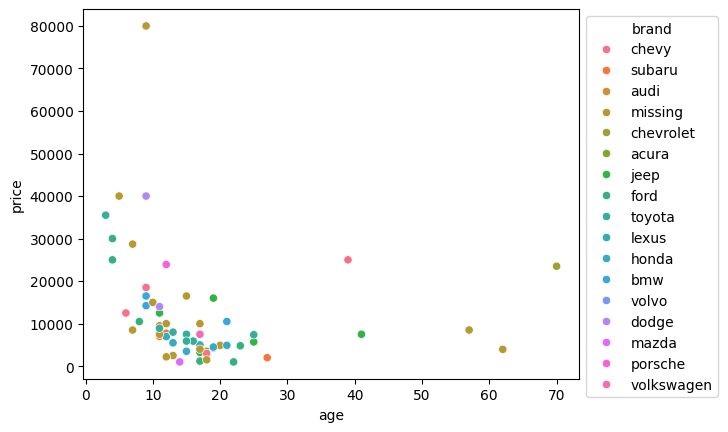

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.943179 -0.251469
log_age    -0.251469  0.364810
           log_price   log_age
log_price   1.000000 -0.433014
log_age    -0.433014  1.000000


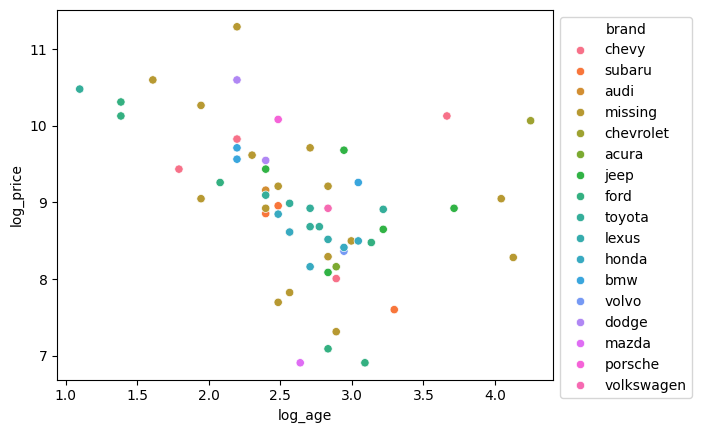

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

               price         year
count     124.000000    17.000000
mean     1580.911290  1978.588235
std     11070.902684    28.095949
min         0.000000  1905.000000
25%        98.750000  1974.000000
50%       237.500000  1977.000000
75%       725.000000  1994.000000
max    123456.000000  2025.000000


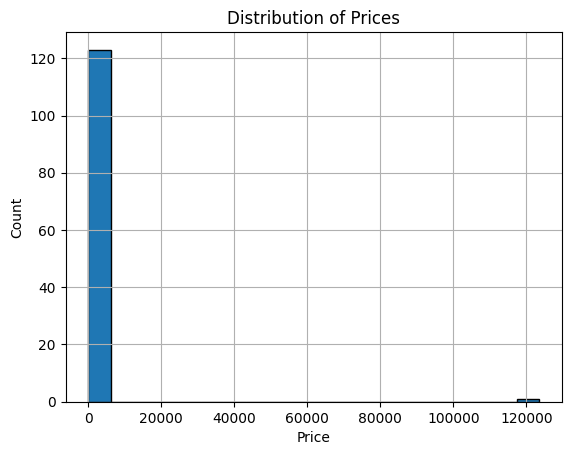

         count         mean           std    min      25%     50%      75%  \
brand                                                                        
martin     4.0  1935.000000    775.596545  900.0  1646.25  2045.0  2333.75   
yamaha     4.0  1836.250000   2397.725919  200.0   646.25   872.5  2062.50   
missing  102.0  1639.058824  12200.600955    0.0    77.50   197.5   400.00   
gibson     3.0   996.666667    872.945206   40.0   620.00  1200.0  1475.00   
fender    11.0   979.454545   1203.059962   30.0   175.00   695.0  1112.50   

              max  
brand              
martin     2750.0  
yamaha     5400.0  
missing  123456.0  
gibson     1750.0  
fender     4100.0  


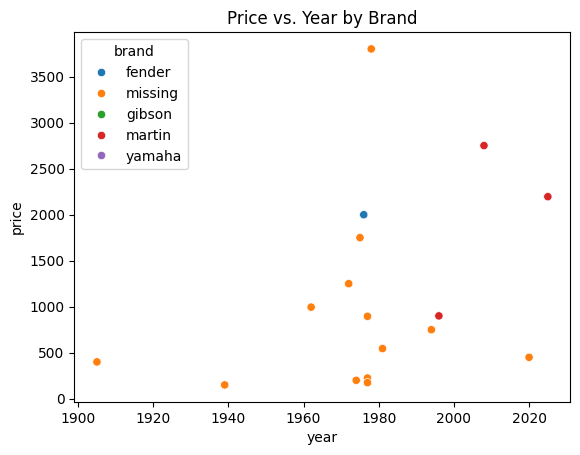

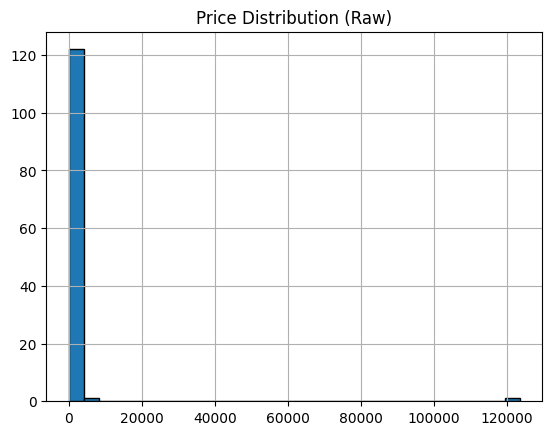

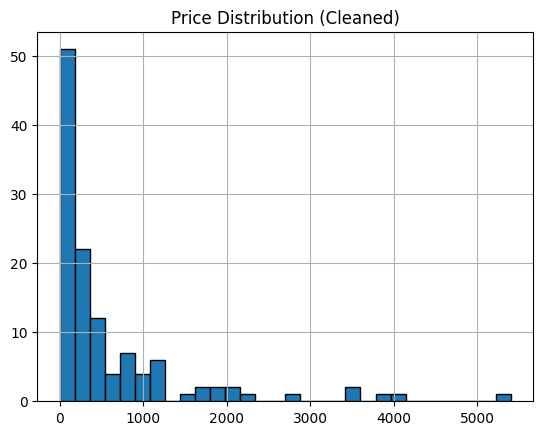

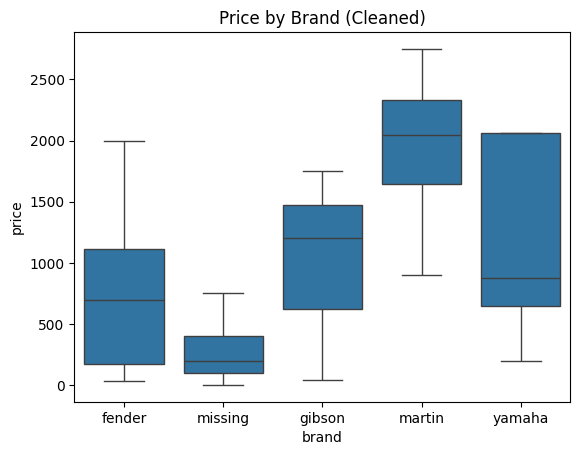

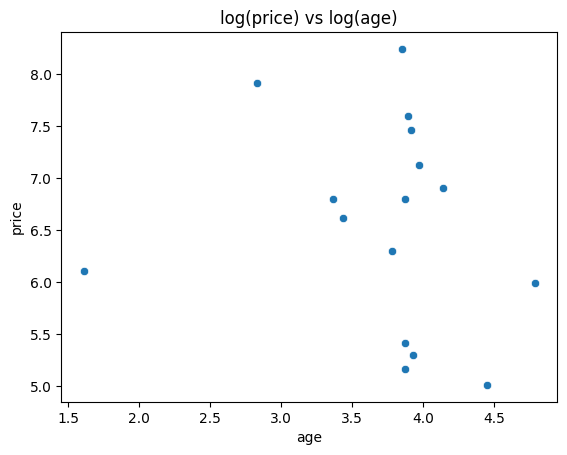

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup as soup

# Request & parse
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
url = 'https://charlottesville.craigslist.org/search/msg'  # Change 'msg' for musical instruments

raw = requests.get(url, headers=header) #Get page
bsObj = soup(raw.content, 'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

brands = ['yamaha', 'fender', 'gibson', 'roland', 'korg', 'casio', 'martin']

# Extract
data = []
for listing in listings:
    try:
        title = listing.find('div', class_='title').get_text().lower()
        price = listing.find('div', class_='price').get_text()
        link = listing.find(href=True)['href']

        words = title.split()
        hits = [word for word in words if word in brands]
        brand = hits[0] if hits else 'missing'

        year_match = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)
        year = year_match.group(0) if year_match else np.nan

        data.append({'title': title, 'price': price, 'link': link, 'brand': brand, 'year': year})
    except Exception as e:
        print(f"Skipping a listing due to error: {e}")

# DataFrame & cleaning
df = pd.DataFrame(data)
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

print(df.describe())

# Plots & summaries
df['price'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

brand_summary = df.groupby('brand')['price'].describe().sort_values(by='mean', ascending=False)
print(brand_summary)

# Scatterplot of price vs. year
if df['year'].notna().sum() > 0:
    sns.scatterplot(data=df, x='year', y='price', hue='brand')
    plt.title('Price vs. Year by Brand')
    plt.show()

df = pd.DataFrame(data)
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

PLACEHOLDERS = {0, 123456}
df_clean = df.loc[~df['price'].isin(PLACEHOLDERS)].copy()

# Hist BEFORE
df['price'].hist(bins=30, edgecolor='black')
plt.title('Price Distribution (Raw)')
plt.show()

# Hist AFTER
df_clean['price'].hist(bins=30, edgecolor='black')
plt.title('Price Distribution (Cleaned)')
plt.show()

# Brand boxplot
top_brands = df_clean['brand'].value_counts().head(6).index
sns.boxplot(data=df_clean[df_clean['brand'].isin(top_brands)],
            x='brand', y='price', showfliers=False)
plt.title('Price by Brand (Cleaned)')
plt.show()

# log(price) vs log(age)
from datetime import datetime
this_year = datetime.now().year
df_clean['age'] = this_year - df_clean['year']
df_log = df_clean.dropna(subset=['age','price'])
df_log = df_log[(df_log['age']>0) & (df_log['price']>0)]
sns.scatterplot(data=df_log, x=np.log(df_log['age']), y=np.log(df_log['price']))
plt.title('log(price) vs log(age)')
plt.show()

We scraped the Charlottesville Craigslist “Musical Instruments” page. For each result we kept the title, price, link, a brand flag pulled from the title (yamaha, fender, gibson, roland, korg, casio, martin; otherwise “missing”), and a four-digit year if the title had one. Our plan was to summarize prices, plot a price histogram, compare prices by brand, and check price versus year.

We used requests with a desktop user-agent and parsed the HTML with BeautifulSoup by selecting rows with cl-static-search-result. We cleaned prices by removing dollar signs and commas and cast both price and year to numeric types.

The scrape returned 142 listings. The median price is 237.50 dollar and most items sit between 100 and 500 dollar. The mean price is 1,366 dollar because one listing shows 123456 dollar, which is an obvious error. Brand detection from titles is sparse: 115 listings fall into “missing,” while Fender has 14, Yamaha 7, Gibson 3, Martin 2, and Casio 1. Using medians, Gibson is about 1,200 dollar, Fender about 612 dollar, Martin about 728 dollar, Yamaha 250 dollar, Casio 250 dollar, and “missing” 175 dollar, so branded guitars tend to list higher. Only 11 listings include a year in the title, ranging from 1905 to 2024, so the price–year scatter does not show a reliable trend. A few entries have 0 dollar prices, which likely indicate placeholders or trades.

If we extend this, we would paginate through more result pages, parse the posting body to improve brand and year detection, add posting date and location, and filter to a sensible price band such as 10 dollar to 10,000 dollar or winsorize the top tail. We would also add boxplots of price by brand and a log-price scatterplot to handle the heavy right tail. After removing placeholder values (0 and 123,456), the cleaned histogram shows a much clearer right-skewed distribution with most listings under 1,500 dollars. The brand-level boxplot highlights that guitars from Martin, Yamaha, Gibson, and Fender generally list higher than unbranded items. The log–log scatter of price versus age suggests a negative trend, though it is limited by the small number of valid year entries. Overall, used instruments here are generally inexpensive, branded guitars run higher, and the cleaned plots give a more reliable picture than the raw data distorted by extreme outliers.